In [1]:
# 导入必要的库
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt # 用于数据可视化
from torch.utils.data import DataLoader, TensorDataset # 用于构造数据加载器
from sklearn.model_selection import train_test_split # 用于划分数据集

#### 数据生成

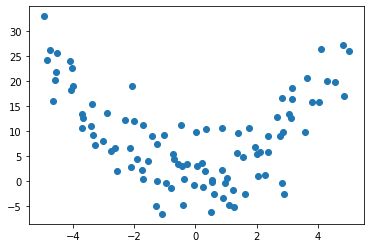

In [2]:
# 设置随机种子
np.random.seed(32)

# 生成满足 y = x^2 + 1 的数据
num_samples = 100 # 100个样本点
X = np.random.uniform(-5, 5, (num_samples, 1)) # 均匀分布
Y = X ** 2 + 1 + 5 * np.random.normal(0, 1, (num_samples, 1)) # 正态分布噪声

# 将 NumPy 变量转化为浮点型 PyTorch 变量
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

# 绘制数据散点图
plt.scatter(X, Y)
plt.show()

In [3]:
# 将数据拆分为训练集和测试集
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=0)

# 将数据封装成数据加载器
train_dataloader = DataLoader(TensorDataset(train_X, train_Y), batch_size=32, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_X, test_Y), batch_size=32, shuffle=False)

#### 模型定义

In [4]:
# 定义线性回归模型（欠拟合）
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# 定义多层感知机（正常）
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

# 定义更复杂的多层感知机（过拟合）
class MLPOverfitting(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(1, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        return self.output(x)

In [5]:
def plot_errors(models, num_epochs, train_dataloader, test_dataloader):
    # 定义损失函数
    loss_fn = nn.MSELoss()

    # 定义训练和测试误差数组
    train_losses = []
    test_losses = []

    # 遍历每类模型
    for model in models:
        # 定义优化器
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

        # 每类模型的训练和测试误差
        train_losses_per_model = []
        test_losses_per_model = []
        
        # 迭代训练
        for epoch in range(num_epochs):
            # 在训练数据上迭代
            model.train()
            train_loss = 0
            # 遍历训练集
            for inputs, targets in train_dataloader:
                # 预测、损失函数、反向传播
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                # 记录loss
                train_loss += loss.item()
            
            # 计算loss并记录
            train_loss /= len(train_dataloader)
            train_losses_per_model.append(train_loss)

            # 在测试数据上评估，测试模型不计算梯度
            model.eval()
            test_loss = 0
            with torch.no_grad():
                # 遍历测试集
                for inputs, targets in test_dataloader:
                    # 预测、损失函数
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)
                    # 记录loss
                    test_loss += loss.item()
            
                # 计算loss并记录
                test_loss /= len(test_dataloader)
                test_losses_per_model.append(test_loss)

        # 记录当前模型每轮的训练测试误差
        train_losses.append(train_losses_per_model)
        test_losses.append(test_losses_per_model)

    return train_losses, test_losses

In [6]:
# 获取训练和测试误差曲线数据
num_epochs = 200
models = [LinearRegression(), MLP(), MLPOverfitting()]
train_losses, test_losses = plot_errors(models, num_epochs, train_dataloader, test_dataloader)

#### 可视化

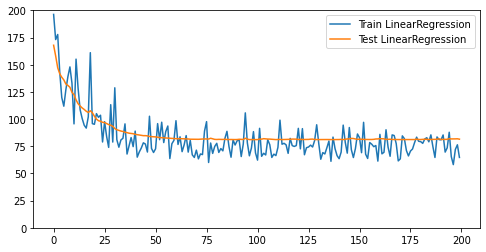

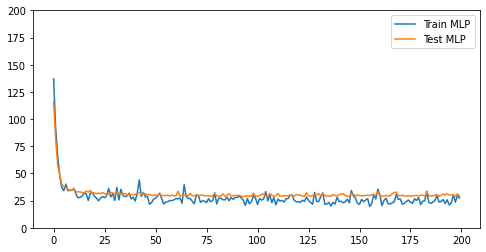

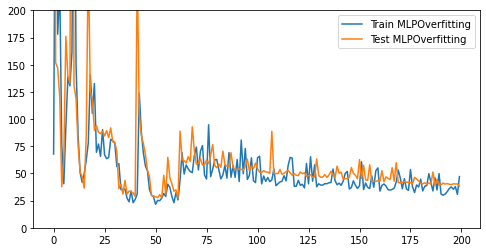

In [7]:
# 绘制训练和测试误差曲线
for i, model in enumerate(models):
    plt.figure(figsize=(8, 4))
    plt.plot(range(num_epochs), train_losses[i], label=f"Train {model.__class__.__name__}")
    plt.plot(range(num_epochs), test_losses[i], label=f"Test {model.__class__.__name__}")
    plt.legend()
    plt.ylim((0, 200))
    plt.show()